In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import csv
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"



In [3]:
base_path = r'C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\\'

ids_path = 'prepeard_data2.csv'
vocab_path = "vocab.csv"

data_len = 2231142

In [4]:
with open(base_path + vocab_path, 'r') as file:
    vocab = [t[0] for t in list(csv.reader(file))[1:]]

print(vocab)

['<UKN>', '<PAD>', '.', '*', ',', 'and', 'the', '1', 'to', 'in', 'a', '2', 'with', '1/2', ')', '(', 'of', 'cup', 'until', 'add', 'for', 'or', 'c.', 'minutes', 'salt', 'sugar', 'into', 'on', 'pepper', 'heat', '3', 'teaspoon', 'butter', '1/4', 'chopped', 'oil', 'over', 'mix', 'cheese', 'water', ';', 'tsp', 'flour', 'large', 'cups', '4', 'cream', 'tablespoons', 'cook', 'pan', 'bowl', 'mixture', 'stir', 'about', 'onion', 'sauce', 'at', 'bake', 'baking', 'chicken', 'can', 'place', 'garlic', 'is', 'milk', 'tbsp', 'oven', 'it', 'medium', 'cut', 'top', 'eggs', 'brown', 'juice', 'ingredients', 'from', 'combine', 'pour', 'tablespoon', 'well', 'small', 'fresh', 'egg', 'remove', '5', 'serve', '8', 'then', 'vanilla', 'ground', 'cool', 'oz', 'powder', 'cover', '6', '12', 'you', 'each', 'all', '10', 'together', 'if', 'lemon', 'sliced', 'olive', '3/4', 'remaining', 'teaspoons', 'let', 'boil', 'set', 'lb', 'sprinkle', 'green', 'onions', ':', 'taste', 'are', 'hot', 'dough', 'as', 'red', 'ounces', 'tomat

In [5]:

vocab =  vocab + ["<ING>", "<REC>"]



w2id =  {w:i for i,w in  enumerate(vocab)}
id2w =  {i:w for i,w in  enumerate(vocab)}

(w2id)["<REC>"]

10001

In [6]:

    
class Generator_next_token(nn.Module):
    def __init__(self, vocab_len, hidden_size, num_layers=1):
        super(Generator_next_token, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_len, embedding_dim=hidden_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_layers * hidden_size, vocab_len)

    def forward(self, input_sequence):
        embedded = self.embedding(input_sequence)
        # input_sequence shape: (batch_size, sequence_length, input_size)
        hidden_states, (h_n, _) = self.rnn(embedded)
        # h_n shape: (num_layers, batch_size, hidden_size)

        # Concatenate or stack hidden states from all layers
        h_n_flat = h_n.permute(1, 0, 2).contiguous().view(input_sequence.size(0), -1)
        
        # Pass through the linear layer

        output = self.fc(h_n_flat)
        # output shape: (batch_size, output_size)
       
        return output, hidden_states

# Example usage
batch_size = 32
sequence_length = 10
input_size = 5
hidden_size = 64
output_size = input_size

# Create an instance of the Generator
generator = Generator_next_token(input_size, hidden_size, 2)

# Generate a random batch of input sequences
input_sequence = torch.randint(0,input_size,(batch_size, sequence_length))

# Forward pass through the generator
output_vector, _ = generator(input_sequence)

print("Input sequence shape:", input_sequence.shape)
print("Output vector shape:", output_vector.shape)


Input sequence shape: torch.Size([32, 10])
Output vector shape: torch.Size([32, 5])


In [7]:


# Define the Generator
class Generator(nn.Module):
    def __init__(self, vocab_len,hidden_size, depth,max_len):
        super(Generator, self).__init__()
        
        self.embedding = nn.Linear(vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=depth, batch_first=True)
        self.hidden2vocab = nn.Linear(hidden_size, vocab_len)
        self.hidden_l = nn.Linear(hidden_size * depth, hidden_size)
        self.max_len = max_len
        

        
        

    def forward(self, input_seq):
        original_input = input_seq.clone()
        sequences = self.embedding(input_seq.float())
        outputs = []
    
        for _ in range(self.max_len):
            last_hidden, hidden_states = self.singel_pass(sequences)
            outputs.append(last_hidden)
            sequences = torch.cat((sequences, last_hidden.unsqueeze(1)), dim = 1)
       
        outputs = torch.stack(outputs, dim = 1)
        vocab_vectors = self.hidden2vocab(outputs)
        vocab_probs = torch.softmax(vocab_vectors, dim=2)
        
        out = torch.concat((original_input,vocab_probs), dim=1)
        return out, hidden_states
            
        

    def singel_pass(self, input_seq):
        rand_source = torch.rand((input_seq.shape[0], 1, input_seq.shape[2])).to(device)
        #embedded = torch.concat((rand_source, embedded), dim = 1)
        hidden_states, (last_hidden, _) = self.rnn(input_seq)
        last_hidden = last_hidden.view(1, -1)
        output = self.hidden_l(last_hidden)
        
        return output, hidden_states


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, vocab_len, hidden_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_len, embedding_dim=hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, input):
        embedded = self.embedding(input)
        hidden_states, (last_hidden, _) = self.rnn(embedded)
        output = self.fc(last_hidden)
        prob = F.sigmoid(output)
        return prob, hidden_states

In [8]:
class CSVDataLoader:
    def __init__(self, csv_file_path, batch_size, num_rows):
        self.csv_file_path = csv_file_path
        self.batch_size = batch_size
        self.num_rows = num_rows
        self.current_index = 0
        self.file_handle = None
        self.csv_writer = None
        self.headers = None

    def open_csv_file(self):
        self.file_handle = open(self.csv_file_path, 'r', newline='')
        self.csv_writer = csv.reader(self.file_handle)
        # Assuming the first row contains headers
        self.headers = next(self.csv_writer)

    def close_csv_file(self):
        if self.file_handle is not None and not self.file_handle.closed:
            self.file_handle.close()

    def reset(self):
        self.close_csv_file()
        self.open_csv_file()
        self.current_index = 0

    def has_next_batch(self):
        return self.current_index < self.num_rows

    def get_next_batch(self, pad):
        ing_batch = [] 
        rec_batch = []
        for _ in range(self.batch_size):
            if not self.has_next_batch():
                break
            ing, rec = next(self.csv_writer)
            ing_batch.append(torch.tensor(eval(ing)).to(device))
            rec_batch.append(torch.tensor(eval(rec)).to(device))
            self.current_index += 1
       
        

        ing_padded = pad_sequence(ing_batch, batch_first=True, padding_value=pad)
        rec_padded = pad_sequence(rec_batch, batch_first=True, padding_value=pad)
        return ing_padded, rec_padded
    
    def batches_left(self):
        return (self.num_rows - self.current_index) // self.batch_size
    
    def __del__(self):
        self.close_csv_file()

In [9]:
for i in range(1,100,10):
    print(F.normalize(torch.tensor([[0.1,0.2,0.5]], dtype=torch.float32) * i, dim = 1))

tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])


In [10]:
"""args = torch.randint(1,100, (1000, 3))
r = torch.arange(2500).view(50, -1)
for b,c,d in tqdm(args):
    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)
    assert(torch.equal(r, h))"""

'args = torch.randint(1,100, (1000, 3))\nr = torch.arange(2500).view(50, -1)\nfor b,c,d in tqdm(args):\n    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)\n    assert(torch.equal(r, h))'

In [11]:
def patch_batch(ings, start, midel):
    start_tokens = torch.full((ings.shape[0],), start).unsqueeze(1).to(device)
    midel_tokens = torch.full((ings.shape[0],), midel).unsqueeze(1).to(device)
    return torch.cat((start_tokens, ings, midel_tokens), dim=1).to(device)


In [12]:
data_path = r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\prepeard_data.csv"
data_loader = CSVDataLoader(data_path, 32, 2231142)
data_loader.open_csv_file()
d = data_loader.get_next_batch(w2id["<PAD>"])
data_loader.close_csv_file()

patch_batch(d[0], w2id["<ING>"], w2id["<REC>"])[0]

tensor([10000,     3,    67,   206,  1827,    96,     4,    59,   345,     2,
           23,   742,    55,   227,     2,     3,    28,    34,    48,   196,
          103,     2,     3,   483,   117,    34,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1, 10001],
       device='cuda:0')

In [13]:
class Dummy_loader:
    def __init__(self, d) -> None:
        self.d = d

    def reset(self):
        pass
    def open_csv_file(self):
        pass
    def batches_left(self):
        return 1

    def get_next_batch(self, a):
        return self.d
    

In [14]:
class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(NextTokenPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

        # Initialize the hidden state as a learnable parameter
        self.init_hidden = nn.Parameter(torch.zeros(1, 1, hidden_dim), requires_grad=True)

    def forward(self, x):
        batch_size = x.size(0)

        # Repeat the initial hidden state for the entire batch
        hidden = (self.init_hidden.repeat(1, batch_size, 1), torch.zeros(1, batch_size, self.hidden_dim).to(device))

        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x[:, -1, :])  # Take the last time step output
        return x

In [27]:
# Hyperparameters
generator_hidden_size = 128
generator_depth = 8
gen_lr  = 0.00001
batch_size = 64
epochs = 1

nr_grads = 4000

In [29]:

#a = CSVDataLoader(r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\dummy_data.csv", 1, 1)
#a.open_csv_file()
#pad1 = w2id["<PAD>"]

#dummy_loader = Dummy_loader(a.get_next_batch(pad1))
data_loader = CSVDataLoader(data_path, batch_size, 2231142)


#data_loader = dummy_loader


data_loader.open_csv_file()
# Instantiate Generator and Discriminator
generator = NextTokenPredictor(len(vocab), generator_hidden_size, generator_hidden_size).to(device)



# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=gen_lr)
max_grad_norm = 1.0
#torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_grad_norm)
#torch.nn.utils.clip_grad_norm_(generator.parameters(), max_grad_norm)


avg_gen_losses = []

progress_bar = tqdm(total=nr_grads)

for epoch in (range(epochs)):
    
    data_loader.reset()
    batch_nr = 0
    total_nr_batches = data_loader.batches_left()
    #total_nr_batches =  100
    itr =(range(total_nr_batches))
    for batch_nr in itr:
        if progress_bar.n == nr_grads:
            pass
        
        # Training the Discriminator
        pad1 = w2id["<PAD>"]
       
   
        real_ingredients, real_recipies = data_loader.get_next_batch(pad1)
        real_patched_ings = patch_batch(real_ingredients, 
                                            w2id["<ING>"],
                                            w2id["<REC>"])
        
        #Generator input does not need to be smoothend
        real_batch = torch.concat((real_patched_ings,
                                     real_recipies), dim = 1)

       
  
        gen_losses = []
        for index in range(real_patched_ings.shape[1],real_batch.shape[1]):
            gen_optimizer.zero_grad()
            sequence_x = real_batch[:,:index]
            tokens_y = torch.nn.functional.one_hot(real_batch[:,index], len(vocab))
             
            generated_logits = generator(sequence_x)
            
            gen_loss = criterion(generated_logits, tokens_y.float())
            gen_loss.backward()
            gen_optimizer.step()

            gen_losses.append(gen_loss.item())
        avg_gen_losses.append(sum(gen_losses) / len(gen_losses))
        progress_bar.update(1)
       
      

    
            

  0%|          | 1/4000 [00:06<7:24:12,  6.66s/it]


17410it [9:35:07,  5.01s/it]                           

KeyboardInterrupt: 

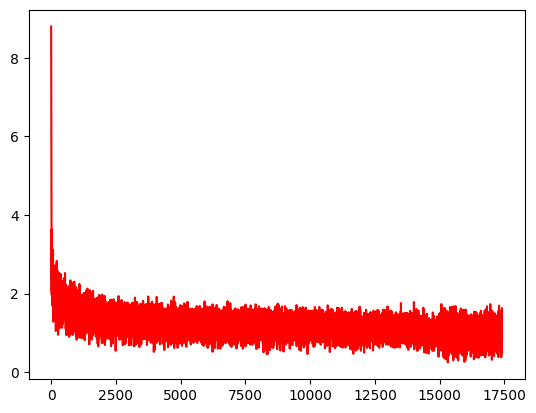

0.4613361656665802

In [30]:
import matplotlib.pyplot as plt
plt.plot(avg_gen_losses, color = "red")
plt.show()
gen_losses[-1]

In [31]:
from nltk.tokenize import word_tokenize

In [32]:
def encode(prompt, dic):
    return [dic.get(t.lower(),dic["<UKN>"]) for t in word_tokenize(prompt)]

In [33]:
encode("1. break milk I brew a cool candy", w2id)

[5182, 733, 64, 209, 3877, 10, 90, 855]

In [34]:
def decode(answer, dic):
    return " ".join([dic[i] for i in answer])

In [35]:
decode(encode("we bake a NLP cake", w2id), id2w)

'we bake a <UKN> cake'

In [36]:
def topk(next_logits, k):
    next_probs = torch.softmax(next_logits, dim=1)
    topk_values, topk_indices = torch.topk(next_probs, k, dim=1)
    topk_values, topk_indices = topk_values.to(device), topk_indices.to(device)
    topk_index_indices = torch.multinomial((topk_values), 1).squeeze(1).to(device)
    next_tokens = topk_indices[
        torch.arange(topk_index_indices.shape[0]), topk_index_indices]
    return next_tokens

In [37]:
def generate(prompt, generator, gen_len, strat):
    t = torch.tensor(encode(prompt, w2id)).unsqueeze(0).to(device)
    batch = (patch_batch(t,
                                w2id["<ING>"],
                                w2id["<REC>"]))
    for _ in range(gen_len):
        answer = generator(batch)
        new_token = strat(answer)
        if id2w[new_token.item()] == "<PAD>":
            break
        batch = torch.concat((batch, new_token.unsqueeze(1)), dim = 1)
        

    return decode([i.item() for i in batch[0]], id2w).split("<REC>")[1]

In [38]:
decode([31, 4028, 208, 16], id2w)

'teaspoon mac will of'

In [40]:
seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
ing = "Big apple * Two large apples * A few apples"

generator.eval()
with torch.no_grad():
    for i in range(10):
        print((generate(ing, generator, 100, lambda p: topk(p,5))))

 cover cheese 1 shredded onions . teaspoon and half the to large minutes * , 2 and tablespoon * tablespoon , cook * sauce 2 and tablespoon , cook , or stir . teaspoon and can the to jello make , baking in food melt , heat ) lemon 1/2 another .
 cream milk 4 the to large minutes . tablespoons cup to before , about oz . cups in it it pan into . heat 3 shredded ) syrup 1/2 ( a cups over cooking , seeded . onion sliced in chicken * ( onion .
 cream and 4 the to slice chili , roasted a water over dough . 2 and at , pepper . 2 1 and 4 , sugar a and into over dough for tablespoons cup and soy salt , heat ) on potatoes . place the to large salt of using . place the and down ) lemon 1/2 stirring cooked .
 until flour the to large vanilla add is finely until . the vanilla add is until * cinnamon a soup oven * butter pour 1/2 . mixture , clove and can for juice boil . 2 and egg * pepper , cook 1 to brown . c. and can the to vanilla add boiling until ) butter on small 1 tsp 1/2 a soup oven * butte